In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
path = Path("games_info_and_reviews.csv")
games_df = pd.read_csv(path)
# Review the DataFrame
games_df.head()

,game_id,game_name,is_free,genres,categories,release_date,price,required_age,review_score_desc,total_positive_reviews,total_negative_reviews,review_score,owners
0,1744330,No More Heroes 3,False,Action,"Single-player, Steam Achievements, Full contro...","11 Oct, 2022",CDN$ 49.99,17,Very Positive,232,46,8,"20,000 .. 50,000"
1,1743380,SCP: Doki Doki Anomaly,False,"Indie, RPG","Single-player, Steam Achievements","7 Oct, 2021",CDN$ 6.69,0,Very Positive,51,4,8,"0 .. 20,000"
2,1742450,西游记2021,False,"Adventure, Casual, Indie, RPG, Strategy",Single-player,"30 Sep, 2021",CDN$ 11.49,0,No user reviews,0,0,0,"50,000 .. 100,000"
3,1742470,My Newborn Life In A Harem,False,"Casual, RPG",Single-player,"29 Mar, 2022",CDN$ 14.49,0,Mixed,18,12,5,"0 .. 20,000"
4,1742500,My Dear Frankenstein -English Edition-,False,Adventure,Single-player,"30 Sep, 2021",CDN$ 5.69,0,4 user reviews,4,0,0,"0 .. 20,000"


In [4]:
print(games_df.dtypes)

game_id                    int64
game_name                 object
is_free                     bool
genres                    object
categories                object
release_date              object
price                     object
required_age              object
review_score_desc         object
total_positive_reviews     int64
total_negative_reviews     int64
review_score               int64
owners                    object
dtype: object


In [5]:
def categorize_main_genre(genres):
    # Define categories based on the first word or specific keywords in the genre
    if genres.startswith('Action, '):
        return 'Action'
    elif genres.startswith('Adventure, '):
        return 'Adventure'
    elif genres.startswith('Animation & Modelling, '):
        return 'Animation & Modelling'
    elif genres.startswith('Audio Production, '):
        return 'Audio Production'
    elif genres.startswith('Casual, '):
        return 'Casual'
    elif genres.startswith('Design & Illustration, '):
        return 'Design & Illustration'
    elif genres.startswith('Early Access, '):
        return 'Early Access'
    elif genres.startswith('Education, '):
        return 'Education'
    elif genres.startswith('Game Development, '):
        return 'Game Development'
    elif genres.startswith('Indie, '):
        return 'Indie'
    elif genres.startswith('Massively Multiplayer, '):
        return 'Massively Multiplayer'
    elif genres.startswith('Racing, '):
        return 'Racing'
    elif genres.startswith('RPG, '):
        return 'RPG'
    elif genres.startswith('Simulation, '):
        return 'Simulation'
    elif genres.startswith('Sports, '):
        return 'Sports'
    elif genres.startswith('Strategy, '):
        return 'Strategy'
    elif genres.startswith('Utilities, '):
        return 'Utilities'
    else:
        return 'Other'  # If the genre doesn't match any predefined category, tag it as 'Other'

# Apply the function to the 'genres' column in your DataFrame
games_df['main_genre'] = games_df['genres'].apply(categorize_main_genre)


In [6]:
games_df.head()

,game_id,game_name,is_free,genres,categories,release_date,price,required_age,review_score_desc,total_positive_reviews,total_negative_reviews,review_score,owners,main_genre
0,1744330,No More Heroes 3,False,Action,"Single-player, Steam Achievements, Full contro...","11 Oct, 2022",CDN$ 49.99,17,Very Positive,232,46,8,"20,000 .. 50,000",Other
1,1743380,SCP: Doki Doki Anomaly,False,"Indie, RPG","Single-player, Steam Achievements","7 Oct, 2021",CDN$ 6.69,0,Very Positive,51,4,8,"0 .. 20,000",Indie
2,1742450,西游记2021,False,"Adventure, Casual, Indie, RPG, Strategy",Single-player,"30 Sep, 2021",CDN$ 11.49,0,No user reviews,0,0,0,"50,000 .. 100,000",Adventure
3,1742470,My Newborn Life In A Harem,False,"Casual, RPG",Single-player,"29 Mar, 2022",CDN$ 14.49,0,Mixed,18,12,5,"0 .. 20,000",Casual
4,1742500,My Dear Frankenstein -English Edition-,False,Adventure,Single-player,"30 Sep, 2021",CDN$ 5.69,0,4 user reviews,4,0,0,"0 .. 20,000",Other


In [7]:
# One-hot encode categorical columns
encoded_df = pd.get_dummies(games_df, columns=['main_genre', 'categories', 'review_score_desc'])


In [8]:
print(encoded_df.dtypes)

game_id                                       int64
game_name                                    object
is_free                                        bool
genres                                       object
release_date                                 object
                                              ...  
review_score_desc_Overwhelmingly Negative     uint8
review_score_desc_Overwhelmingly Positive     uint8
review_score_desc_Positive                    uint8
review_score_desc_Very Negative               uint8
review_score_desc_Very Positive               uint8
Length: 1848, dtype: object


In [12]:
# Replace empty strings with NaN (missing value)
encoded_df['price'] = encoded_df['price'].replace('', np.nan)

In [13]:
# Replace non-numeric characters with empty strings
encoded_df['price'] = encoded_df['price'].str.replace(r'[^0-9.]', '', regex=True)

# Convert the column to float, coercing errors to NaN
encoded_df['price'] = pd.to_numeric(encoded_df['price'], errors='coerce')


In [19]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Specify the numerical columns to scale
numerical_columns = ['price', 'total_positive_reviews', 'total_negative_reviews', 'review_score']

# Apply MinMax scaling to the numerical columns
encoded_df[numerical_columns] = scaler.fit_transform(encoded_df[numerical_columns])


In [20]:
encoded_df.head()

,game_id,game_name,is_free,genres,release_date,price,required_age,total_positive_reviews,total_negative_reviews,review_score,...,review_score_desc_Mixed,review_score_desc_Mostly Negative,review_score_desc_Mostly Positive,review_score_desc_Negative,review_score_desc_No user reviews,review_score_desc_Overwhelmingly Negative,review_score_desc_Overwhelmingly Positive,review_score_desc_Positive,review_score_desc_Very Negative,review_score_desc_Very Positive
0,1744330,No More Heroes 3,False,Action,"11 Oct, 2022",0.000643,17,0.000467,0.000689,0.888889,...,0,0,0,0,0,0,0,0,0,1
1,1743380,SCP: Doki Doki Anomaly,False,"Indie, RPG","7 Oct, 2021",0.000081,0,0.000103,0.000060,0.888889,...,0,0,0,0,0,0,0,0,0,1
2,1742450,西游记2021,False,"Adventure, Casual, Indie, RPG, Strategy","30 Sep, 2021",0.000143,0,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0
3,1742470,My Newborn Life In A Harem,False,"Casual, RPG","29 Mar, 2022",0.000182,0,0.000036,0.000180,0.555556,...,1,0,0,0,0,0,0,0,0,0
4,1742500,My Dear Frankenstein -English Edition-,False,Adventure,"30 Sep, 2021",0.000068,0,0.000008,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


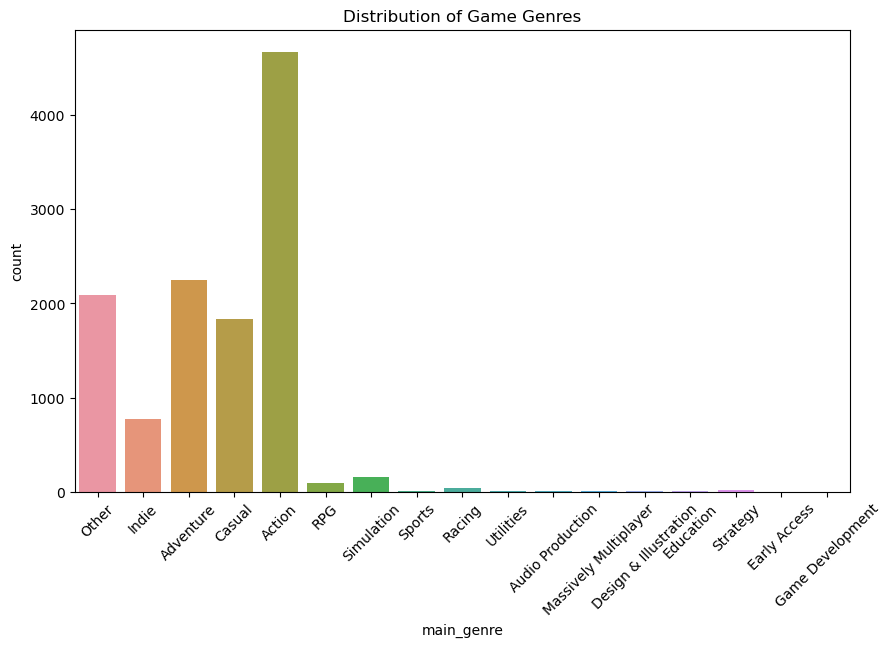

In [17]:
# Visualize genre distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=games_df, x='main_genre')
plt.xticks(rotation=45)
plt.title('Distribution of Game Genres')
plt.show()


In [41]:
import re

def preprocess_owners(owners):
    if pd.isnull(owners):
        return None  # Handle missing values
    # Extract the numeric part before '..' separator
    cleaned_owners = re.search(r'^(\d+)', str(owners))
    if cleaned_owners:
        return float(cleaned_owners.group(1))
    else:
        return None  # Handle cases where the pattern is not found


# Preprocess 'owners' column
encoded_df['owners'] = encoded_df['owners'].apply(preprocess_owners)

# Drop rows with missing values in 'owners' column
encoded_df.dropna(subset=['owners'], inplace=True)

# Select Features and Target Variable
features = ['price', 'total_positive_reviews', 'total_negative_reviews', 'owners']
X = encoded_df[features]
y = encoded_df['review_score']

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Machine Learning Model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate Model Performance
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 0.33636998708260757
Mean Squared Error: 0.12691494477417442
R-squared: 0.10877386828851521


In [39]:
# Check for missing values in each column
missing_values = encoded_df.isna().sum()

# Print columns with missing values
print(missing_values[missing_values > 0])


Series([], dtype: int64)


In [38]:
# Drop rows with missing values
encoded_df.dropna(subset=['release_date', 'price'], inplace=True)


In [42]:
encoded_df.head()

,game_id,game_name,is_free,genres,release_date,price,required_age,total_positive_reviews,total_negative_reviews,review_score,...,review_score_desc_Mixed,review_score_desc_Mostly Negative,review_score_desc_Mostly Positive,review_score_desc_Negative,review_score_desc_No user reviews,review_score_desc_Overwhelmingly Negative,review_score_desc_Overwhelmingly Positive,review_score_desc_Positive,review_score_desc_Very Negative,review_score_desc_Very Positive
0,1744330,No More Heroes 3,False,Action,"11 Oct, 2022",0.000643,17,0.000467,0.000689,0.888889,...,0,0,0,0,0,0,0,0,0,1
1,1743380,SCP: Doki Doki Anomaly,False,"Indie, RPG","7 Oct, 2021",0.000081,0,0.000103,0.000060,0.888889,...,0,0,0,0,0,0,0,0,0,1
2,1742450,西游记2021,False,"Adventure, Casual, Indie, RPG, Strategy","30 Sep, 2021",0.000143,0,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0
3,1742470,My Newborn Life In A Harem,False,"Casual, RPG","29 Mar, 2022",0.000182,0,0.000036,0.000180,0.555556,...,1,0,0,0,0,0,0,0,0,0
4,1742500,My Dear Frankenstein -English Edition-,False,Adventure,"30 Sep, 2021",0.000068,0,0.000008,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Select Features and Target Variable
genre_features = ['main_genre_Action', 'main_genre_Adventure', 'main_genre_Audio Production', 'main_genre_Casual', 'main_genre_Design & Illustration', 'main_genre_Early Access', 'main_genre_Education', 'main_genre_Game Development', 'main_genre_Indie', 'main_genre_Massively Multiplayer', 'main_genre_Other', 'main_genre_RPG', 'main_genre_Racing', 'main_genre_Simulation', 'main_genre_Sports', 'main_genre_Strategy', 'main_genre_Utilities']
other_features = ['price', 'total_positive_reviews', 'total_negative_reviews', 'owners']
X = encoded_df[genre_features + other_features]
y = encoded_df['review_score']

# Split Data into Training and Testing Sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Machine Learning Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate Model Performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 0.33432592314937726
Mean Squared Error: 0.12672490447287196
R-squared: 0.11010837529161432


NameError: name 'owners' is not defined